Importing libraries

In [1]:
#introducing libraries
!pip install numpy scipy pandas>1.0 matplotlib lmfit colour

In [2]:
#calling up libraries
from datetime import datetime
import pandas as pd
import numpy as np
import scipy
import scipy.integrate as integrate
from scipy.integrate import quad
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from mpl_toolkits import mplot3d
from datetime import timedelta
from lmfit.models import LorentzianModel
import statistics
from matplotlib.collections import LineCollection 

Importing data from google drive folder, sorting each into absorbance, spectroscope runs, and general spectroscope data.

In [4]:
#import CSV data from drive
from google.colab import drive
import glob
import os
drive.mount('drive', force_remount=True)
folder = "/content/drive/MyDrive/19_03_2021_Dan/Dan F"
all_files = glob.glob(os.path.join(folder, '*.csv'))
Spec_data = {}
Sorb_data = {}
Irr_data = {}
titles = []



for filename in all_files:
  #Simplify name
  new_name = filename.replace(".csv", "").replace("/content/drive/MyDrive/19_03_2021_Dan/Dan F","")
  #import data
  df = pd.read_csv(filename, sep=',', header=0)
  #Some cleaning
  df = df.rename(columns={'0.00000E+0':'Wavelength(nm)'})
  df.drop(df.head(4).index, inplace=True)
  df = df.set_index('Wavelength(nm)')
  #get rid of bottom info rows
  df = df.dropna(thresh=3)
  #Get rid of first two columns
  df = df.dropna(axis=1)
  #change strings to numbers
  df.index = pd.to_numeric(df.index, errors='ignore')
  df.columns = np.around(pd.to_numeric(df.columns, errors='ignore')).astype(int)

  titles.append(new_name)
  Spec_data[new_name] = df

Spec_data










Mounted at drive


{'/PBDBT_532nm_0p25mW_magicangle -bg -chirp':                    -5        -5        -5     ...      3697      4004      4336
 Wavelength(nm)                                ...                              
 368.969        -0.000024  0.000023 -0.000094  ... -0.000412 -0.000122  0.000791
 369.544         0.000476 -0.000075  0.000226  ... -0.000332  0.000044 -0.000397
 370.118        -0.000114  0.000427  0.000255  ...  0.000009 -0.000375 -0.000155
 370.693         0.000087 -0.000127  0.000078  ... -0.000301 -0.000004  0.000015
 371.268         0.000359  0.000024 -0.000287  ... -0.000298  0.000098 -0.000345
 ...                  ...       ...       ...  ...       ...       ...       ...
 725.020         0.000140  0.000174  0.000084  ...  0.001326  0.000782  0.000918
 725.618        -0.000152  0.000328  0.000159  ...  0.001033  0.000909  0.001316
 726.217        -0.000124 -0.000155  0.000062  ...  0.001489  0.000864  0.000714
 726.815         0.000274  0.000614  0.000039  ...  0.001194  0.

In [ ]:
  #Group data and set relevant metadata
  if "Absorbance" in new_name:
    df.columns = ['Wavelength(nm)', 'Absorbance']
    df.index = df['Wavelength(nm)']
    new_name = new_name.split("_", 1)[0]
    df.title = new_name + ' Absorbance'
    df.title2 = new_name
    Sorb_data[new_name +" "+ str(df.rec_time)] = df

  elif "Subt" in new_name: 
    df.columns = ['Wavelength(nm)', 'Counts']
    df.index = df['Wavelength(nm)']
    new_name = new_name.split("_", 1)[0]
    df.title = new_name + ' Spectrograph ' 
    df.title2 = new_name
    Spec_data[new_name +" "+ str(df.rec_time)] = df
    
  elif "HRD0" in new_name:
    df.columns = ['Wavelength(nm)', 'Counts']
    df.index = df['Wavelength(nm)']
    df['Power(W)'] = df['Counts']*1e-6/df.int_time 
    new_name = new_name.split("_", 1)[0]
    df.title = new_name + ' Energy Spectrum'
    df.title2 = new_name
    Irr_data[new_name +" "+ str(df.rec_time)] = df
  else:
    df.columns = ['Wavelength(nm)', '???']
    df.title = new_name + '???'
  #Put names for each test in a list
  titles.append(new_name)

In [ ]:
def tauc_plot(data, len):
  data['Energy (eV)'] = 1240/data['Wavelength(nm)']
  data['Tauc value'] = (data['Absorbance']*data['Energy (eV)']*2.4/len)**2

In [ ]:
#Looking at Absorbance data
for name in Sorb_data:
  #excepting extra copies
  if Sorb_data[name].title2 == 'P3HTPCBM6' and Sorb_data[name].rec_time >= datetime(2020, 12, 4, 13, 0, 0).time():
    blah=0
  else:

    fig, ax = plt.subplots()
    ax.set_xlabel('Wavelength(nm)')
    ax.set_ylabel('Absorbance')
    ax.set_title(Sorb_data[name].title2 + ' Absorbance')
    for i in range(len(Sorb_data[name]['Absorbance'])):
      if all(Sorb_data[name]['Absorbance'][i:i+100] < 0.1) and all(Sorb_data[name]['Absorbance'][i:i+100] > -0.1):
        Eg = Sorb_data[name]['Wavelength(nm)'].index[i]
        break
      else:
        Eg = 0
    plt.axvline(x = Eg, label = "Eg")



    plt.plot(np.asarray(Sorb_data[name]['Wavelength(nm)']), np.asarray(Sorb_data[name]['Absorbance']))

In [ ]:
for spec in Spec_data:
    fig, ax = plt.subplots()
    ax.set_xlabel('Wavelength(nm)')
    ax.set_ylabel('Flux (Counts/s)')
    ax.set_title(Spec_data[spec].title)

    plt.plot(np.asarray(Spec_data[spec]['Wavelength(nm)']), np.asarray(Spec_data[spec]['Counts'])/Spec_data[spec].int_time)

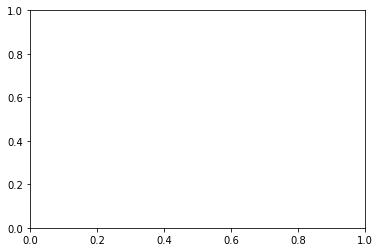

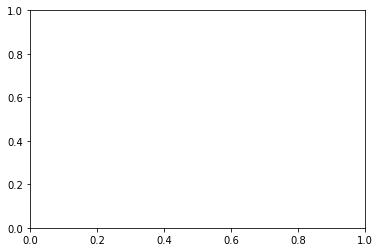

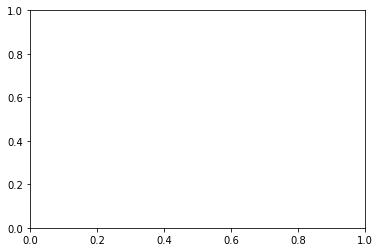

In [5]:
def spec_laser_data(name):
  plt.subplots()
  for spec in sorted(Spec_data):
    if spec[:(len(name))] == name and spec[(len(name)+1):] < '11:38:00' and name == 'MAPI4':
      plt.plot(np.asarray(Spec_data['MAPI4 11:16:31']['Wavelength(nm)'][Spec_data['MAPI4 11:16:31']['Wavelength(nm)'].between(404,410)]), np.asarray(Spec_data[spec]['Counts'][Spec_data['MAPI4 11:16:31']['Wavelength(nm)'].between(404,410)])/Spec_data[spec].int_time, label=spec[(len(name)+1):])
      plt.legend(title='Timestamp')
      plt.title(name + " Transient Spectroscopy")
      plt.xlabel('Wavelength(nm)')
      plt.ylabel('Flux(Counts/s)')
    elif spec[:(len(name))] == name and name != 'MAPI4':
      plt.plot(np.asarray(Spec_data['MAPI4 11:16:31']['Wavelength(nm)'][Spec_data['MAPI4 11:16:31']['Wavelength(nm)'].between(404,410)]), np.asarray(Spec_data[spec]['Counts'][Spec_data['MAPI4 11:16:31']['Wavelength(nm)'].between(404,410)])/Spec_data[spec].int_time, label=spec[(len(name)+1):])
      plt.legend(title='Timestamp')
      plt.title(name + " Transient Spectroscopy")
      plt.xlabel('Wavelength(nm)')
      plt.ylabel('Flux(Counts/s)')
spec_laser_data('MAPI4')
plt.show()
spec_laser_data('TC6')
plt.show()
spec_laser_data('p3htf8b2')
plt.show()


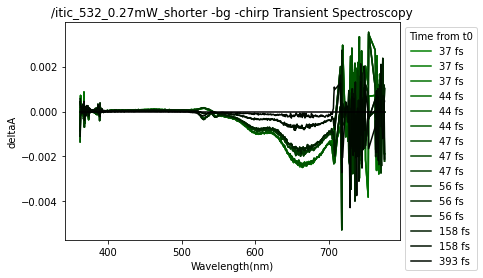

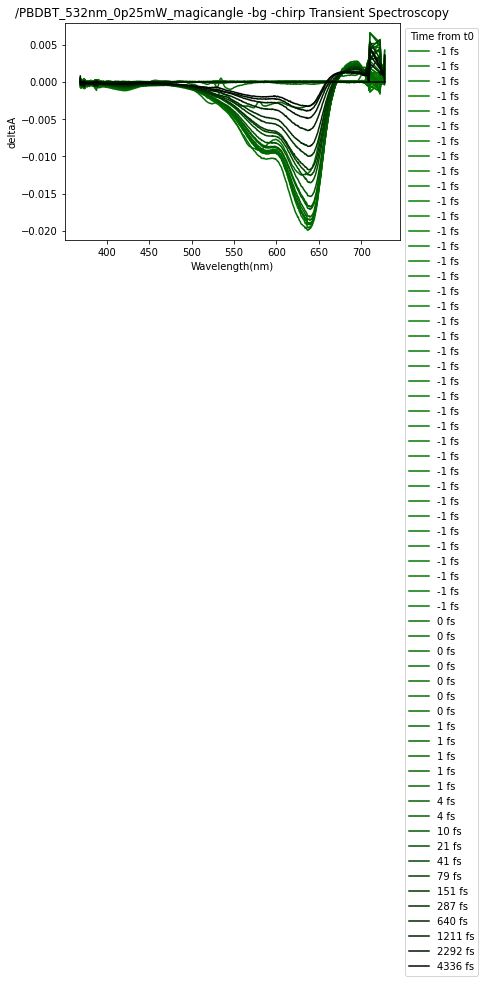

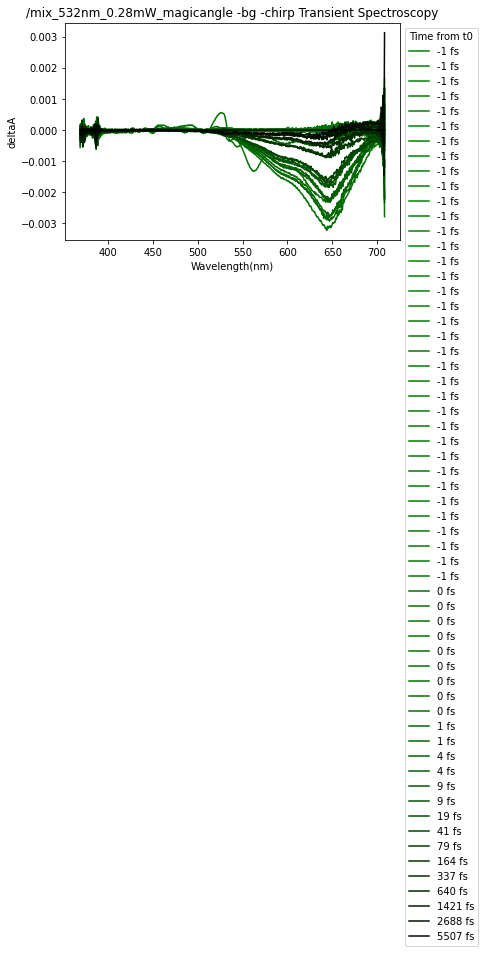

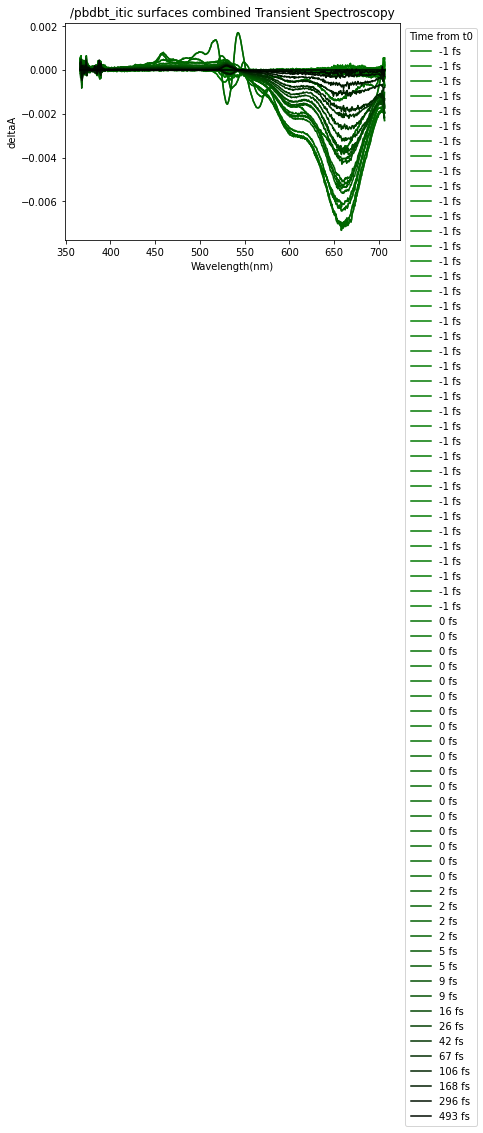

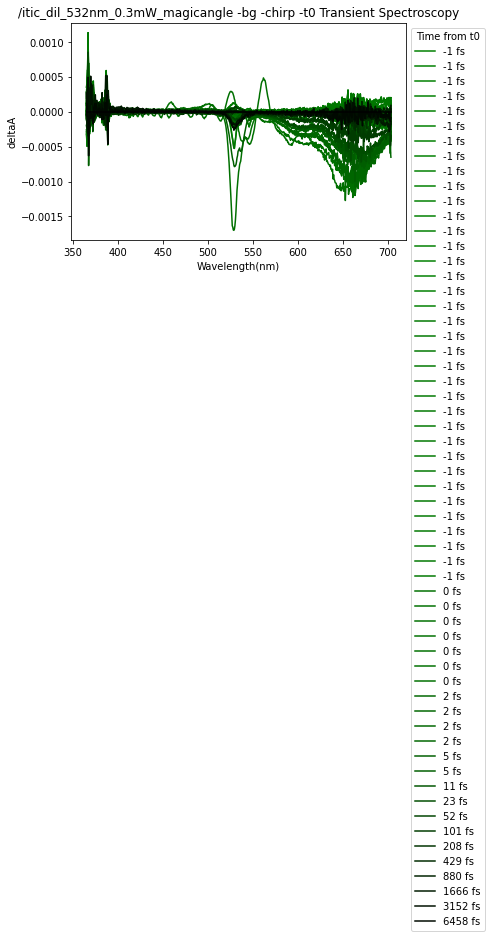

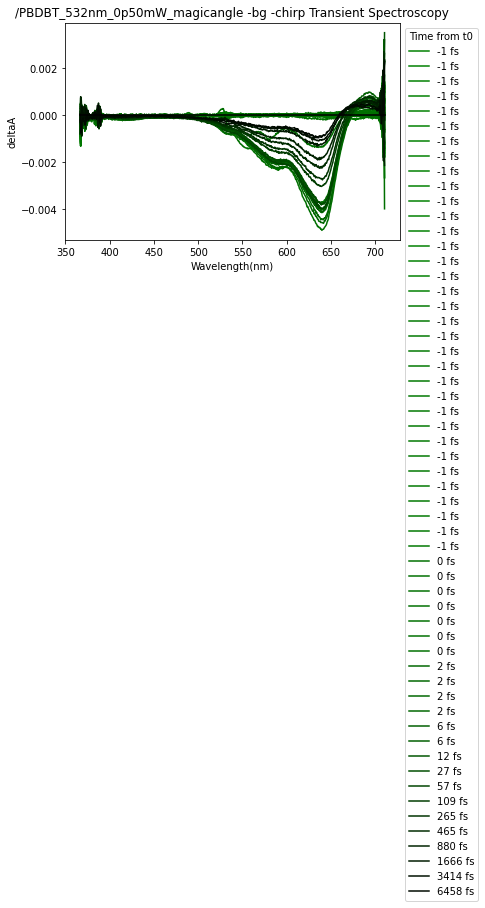

In [16]:
def spec_time_data(name, times):
  plt.subplots()
  for i in range(len(times)):
      plt.plot(np.asarray(Spec_data[name].index), np.asarray(Spec_data[name][times[i]]), label=str(times[i])+' fs', color=colorFader(c1,c2,i/n))
      plt.legend(title='Time from t0', bbox_to_anchor=(1,1), loc="upper left")
      plt.title(name + " Transient Spectroscopy")
      plt.xlabel('Wavelength(nm)')
      plt.ylabel('deltaA')
#color method from stack exchange :https://stackoverflow.com/questions/25668828/how-to-create-colour-gradient-in-python
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)
c1='green' 
c2='black' 
n=15
for name in Spec_data:
  dex = np.floor(np.linspace(20, len(Spec_data[name].columns)-1, num=n))
  times = Spec_data[name].iloc[:,dex].columns
  spec_time_data(name, times)
  plt.plot(np.array(Spec_data[name].index), np.zeros(len(Spec_data[name].index), dtype=float, order='C'), color='black')
  plt.show()





  

In [ ]:
#code from https://blog.finxter.com/matplotlib-3d-plot-advanced/
for name in spec_groups:
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(111, projection='3d')
  # Create x and y 1D arrays
  a = []
  z = []
  max_data = []
  start_time = spec_groups[name][0].split()[1]
  for spec in spec_groups[name]:
    a.append(float((pd.to_timedelta(str(Spec_data[spec].rec_time)) - pd.to_timedelta('0 days ' + start_time))/timedelta(minutes = 1)))
    z.append(np.asarray(Spec_data[spec]['Counts'][Spec_data['degradedopv10ms 12:41:26']['Wavelength(nm)'].between(600,900)]))
    max_data.append(np.asarray(Spec_data[spec]['Counts'].max()))
  b = np.asarray(Spec_data[spec]]['Wavelength(nm)'])
  print(max_data)
  a = np.asarray(a)
  x,y = np.meshgrid(b, a)

  # Create X and Y 2D arrays
  blah = np.asarray(z)

  # Plot using Axes notation
  ax.plot_surface(x, y, blah, cmap='copper')
  ax.plot_wireframe(x, y, blah, rcount = len(spec_groups[name]), ccount =8, color='green')
  # Set axes lables
  ax.set(xlabel='Wavelength(nm)', ylabel='time (minutes)', zlabel='Counts')
  ax.view_init(elev=20, azim=100)
  ax.title.set_text(name + ' Transient Spectroscopy')
  plt.show()


SyntaxError: ignored

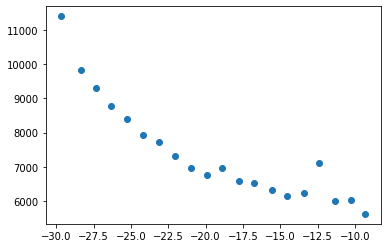

In [ ]:
#merge later, data analysis
name = "MAPI4"
a = []
xmax = []
for spec in sorted(Spec_data):
  if spec[:(len(name))] == name and spec[(len(name)+1):] < '11:38:00' and name == 'MAPI4':
    xmax.append(((Spec_data[spec]['Counts'].max())))
    a.append((pd.to_timedelta(str(Spec_data[spec].rec_time)) - pd.to_timedelta('0 days 11:46:13'))/timedelta(minutes = 1))

plt.scatter(np.asarray(a), (np.asarray(xmax)))



In [ ]:
laser_data = {}
for data in Spec_data:
  df = Spec_data[data][Spec_data[data]['Wavelength(nm)'].between(402,410)]
  df.title = data
  df.rec_time = Spec_data[data].rec_time
  df.int_time = Spec_data[data].int_time
  laser_data[data] = df



In [ ]:
def beam_fit(data):
  #from https://stackoverflow.com/questions/49370795/lorentzian-module
  #from https://millenia.cars.aps.anl.gov/software/python/lmfit/examples/example_use_pandas.html

  data.reset_index(level=0, inplace =True, drop=True)
  model = GaussianModel()
  params = model.guess(data['Counts'], x=data['Wavelength(nm)'])

  result = model.fit(data['Counts'], params, x=data['Wavelength(nm)'])

  result.plot_fit()

 

  data.center = float(result.fit_report()[result.fit_report().find('center:')+12:result.fit_report().find('center:')+18])
  data.sigma = float(result.fit_report()[result.fit_report().find('sigma:')+12:result.fit_report().find('sigma:')+18])
  data.amplitude = float(result.fit_report()[result.fit_report().find('amplitude:')+12:result.fit_report().find('amplitude:')+18])
  data.height = float(result.fit_report()[result.fit_report().find('height:')+12:result.fit_report().find('height:')+18])
  


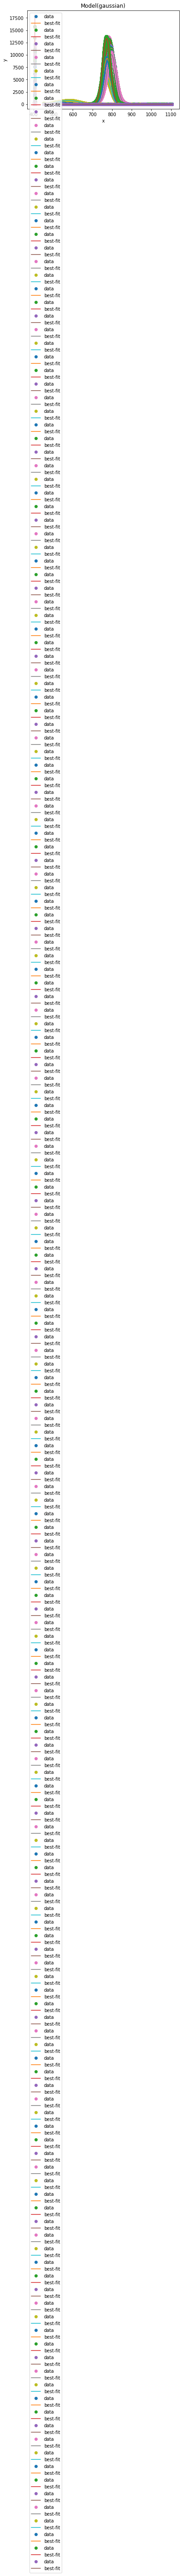

In [ ]:
for data in laser_data:
  beam_fit(laser_data[data])
for data in Spec_data:
  transdata = Spec_data[data][Spec_data[data]['Wavelength(nm)'] > 450]
  beam_fit(transdata)
  transdata.center = Spec_data[data].center
  transdata.sigma = Spec_data[data].sigma
  transdata.amplitude = Spec_data[data].amplitude
  transdata.height = Spec_data[data].height


In [ ]:
#time grouped data
spec_groups = {'MAPI4':[], 'TC6':[], 'p3htf8b2':[], 'roomlight':[], 'degraded':[], 'Subt53':[], 'p3htpcbm':[], 'MAPI4 short':[], 'TC2':[]}
for name in spec_groups:
  for spec in sorted(Spec_data):
    if spec[:(len(name))] == name and spec[(len(name)+1):] < '11:38:05' and name == 'MAPI4':
      spec_groups[name].append(spec)
    elif spec[:(len(name))] == name and name == 'MAPI4':
      spec_groups['MAPI4 short'].append(spec)
    elif spec[:(len(name))] == name and name != 'MAPI4':
      spec_groups[name].append(spec)
  

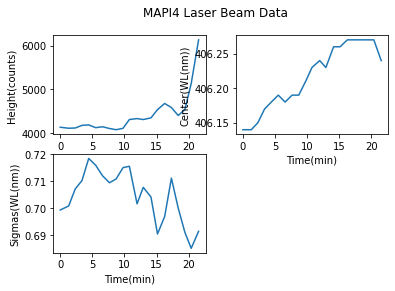

Wavelength Average: 406.21666666666664


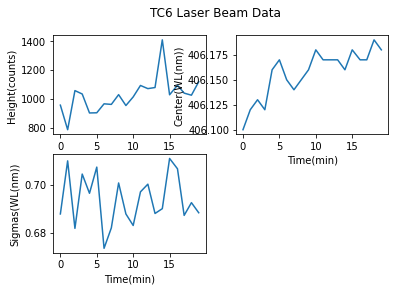

Wavelength Average: 406.157


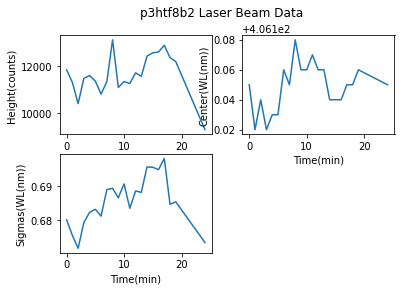

Wavelength Average: 406.1485714285714


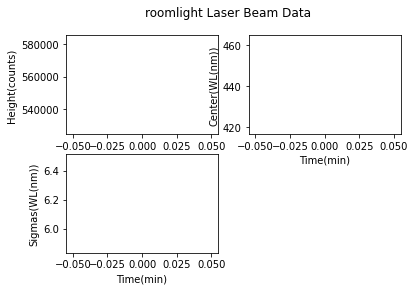

Wavelength Average: 440.72


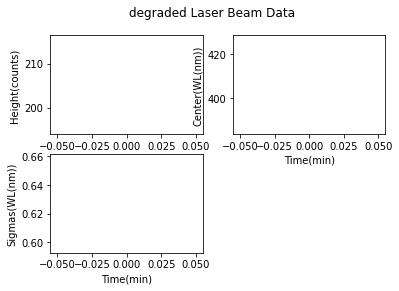

Wavelength Average: 406.15


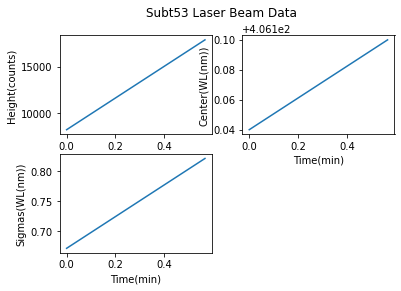

Wavelength Average: 406.16999999999996


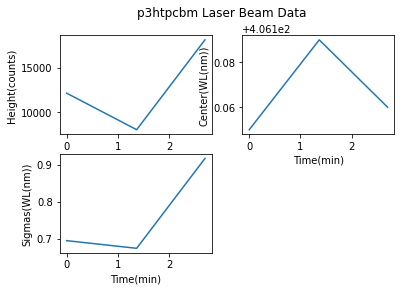

Wavelength Average: 406.1666666666667


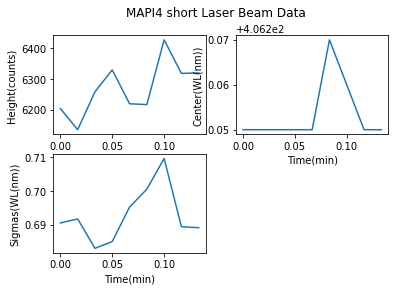

Wavelength Average: 406.25333333333333


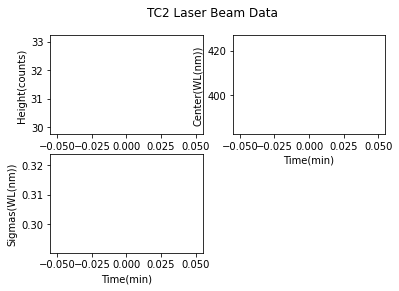

Wavelength Average: 404.58


In [ ]:
#Various transient bandwidth data

for name in spec_groups:
  heights = []
  centers = []
  sigmas = []
  times = []
  start_time = spec_groups[name][0].split()[1]
  for spec in spec_groups[name]:
    beam_fit(laser_data[spec])
    centers.append(laser_data[spec].center)
    heights.append(laser_data[spec].height)
    sigmas.append(laser_data[spec].sigma)
    times.append(float((pd.to_timedelta(str(Spec_data[spec].rec_time)) - pd.to_timedelta('0 days ' + start_time))/timedelta(minutes = 1)))
  plt.subplot(2,2,1)
  plt.plot(times, heights)
  plt.xlabel('Time(min)')
  plt.ylabel('Height(counts)')
  plt.subplot(2,2,2)
  plt.plot(times, centers)
  plt.xlabel('Time(min)')
  plt.ylabel('Center(WL(nm))')
  plt.subplot(2,2,3)
  plt.plot(times, sigmas)
  plt.xlabel('Time(min)')
  plt.ylabel('Sigmas(WL(nm))')
  plt.suptitle(name + " Laser Beam Data")
  plt.show()
  print('Wavelength Average: ' + str(statistics.mean(centers)))


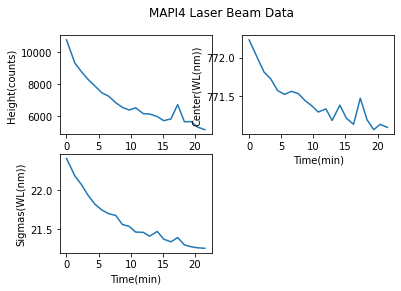

Wavelength Average: 771.4380952380952


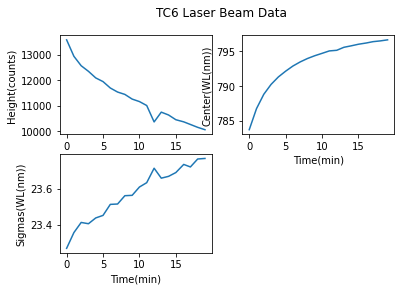

Wavelength Average: 793.261


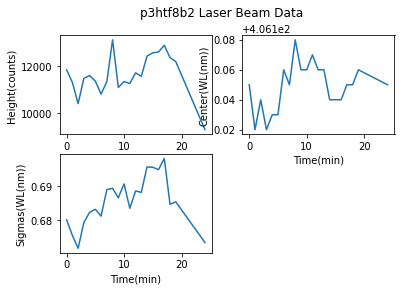

Wavelength Average: 406.1485714285714


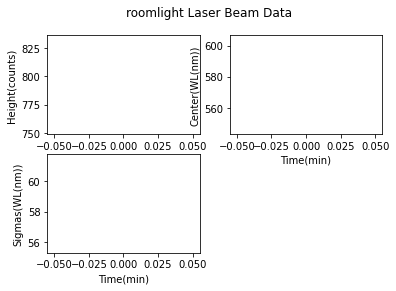

Wavelength Average: 574.91


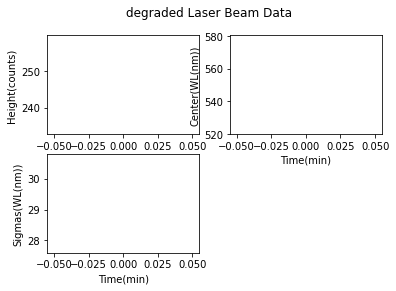

Wavelength Average: 550.11


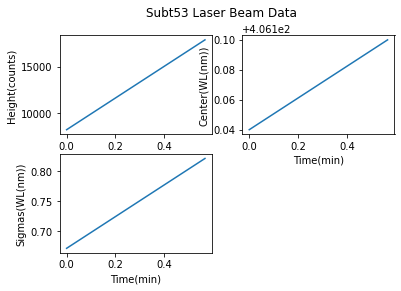

Wavelength Average: 406.16999999999996


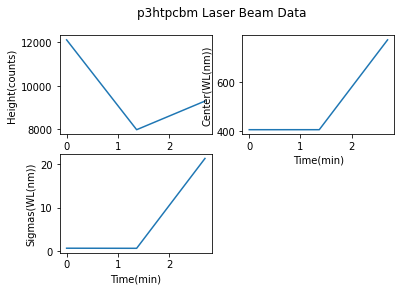

Wavelength Average: 529.0899999999999


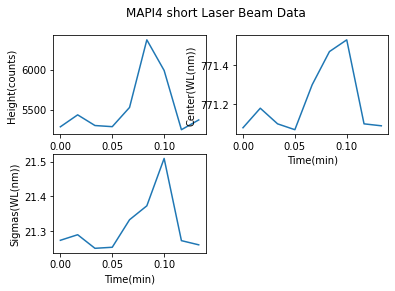

Wavelength Average: 771.2133333333334


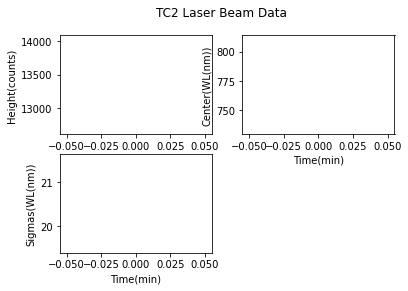

Wavelength Average: 771.66


In [ ]:
for name in spec_groups:
  heights = []
  centers = []
  sigmas = []
  times = []
  start_time = spec_groups[name][0].split()[1]
  for spec in spec_groups[name]:
    beam_fit(Spec_data[spec])
    centers.append(Spec_data[spec].center)
    heights.append(Spec_data[spec].height)
    sigmas.append(Spec_data[spec].sigma)
    times.append(float((pd.to_timedelta(str(Spec_data[spec].rec_time)) - pd.to_timedelta('0 days ' + start_time))/timedelta(minutes = 1)))
  plt.subplot(2,2,1)
  plt.plot(times, heights)
  plt.xlabel('Time(min)')
  plt.ylabel('Height(counts)')
  plt.subplot(2,2,2)
  plt.plot(times, centers)
  plt.xlabel('Time(min)')
  plt.ylabel('Center(WL(nm))')
  plt.subplot(2,2,3)
  plt.plot(times, sigmas)
  plt.xlabel('Time(min)')
  plt.ylabel('Sigmas(WL(nm))')
  plt.suptitle(name + " Laser Beam Data")
  plt.show()
  print('Wavelength Average: ' + str(statistics.mean(centers)))